In [24]:
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow import keras


train = pd.read_csv("data/segmentation_target.test")
test = pd.read_csv("data/segmentation_target.data")

print(f"{train.shape=}")
print(f"{test.shape=}")

val_dataframe = train.sample(frac=1)
train_dataframe = test.sample(frac=1)

print(
    "Using %d samples for training and %d for validation"
    % (len(train_dataframe), len(val_dataframe))
)

train.values

train.shape=(2100, 20)
test.shape=(210, 20)
Using 210 samples for training and 2100 for validation


array([[110.        , 189.        ,   9.        , ...,   0.50813884,
          1.9108642 ,   0.        ],
       [ 86.        , 187.        ,   9.        , ...,   0.46332908,
          1.9414649 ,   0.        ],
       [225.        , 244.        ,   9.        , ...,   0.48014903,
          1.9879022 ,   0.        ],
       ...,
       [128.        , 161.        ,   9.        , ...,   0.5409177 ,
         -1.9963073 ,   3.        ],
       [150.        , 158.        ,   9.        , ...,   0.50308645,
         -1.9434487 ,   3.        ],
       [124.        , 162.        ,   9.        , ...,   0.4799313 ,
         -2.0293121 ,   3.        ]])

In [3]:
max_seqlen = 150
batch_size = 128
padding_token = "<pad>"
auto = tf.data.AUTOTUNE


def dataframe_to_dataset(dataframe):
    dataframe = dataframe.copy()
    dataframe["TARGET"] = dataframe["TARGET"].apply(lambda a: str(a))
    print(dataframe["TARGET"].values[:10])


    ###

    # terms = tf.ragged.constant(dataframe["TARGET"].values)
    # lookup = tf.keras.layers.StringLookup(output_mode="multi_hot")
    # lookup.adapt(terms)
    # vocab = lookup.get_vocabulary()
    #
    # def invert_multi_hot(encoded_labels):
    #     """Reverse a single multi-hot encoded label to a tuple of vocab terms."""
    #     hot_indices = np.argwhere(encoded_labels == 1.0)[..., 0]
    #     return np.take(vocab, hot_indices)


    # print("Vocabulary:")
    # print(vocab)

    ###
    #
    # sample_label = dataframe["TARGET"].iloc[0]
    # print(f"Original label: {sample_label}")
    #
    # label_binarized = lookup([sample_label])
    # print(f"Label-binarized representation: {label_binarized}")

    ###

    # labels = tf.ragged.constant(dataframe["TARGET"].values)
    # label_binarized = lookup(labels).numpy()
    #
    # dataframe.pop("TARGET")
    #
    # print("label_binarized:\n", label_binarized)

    ###

    labels = dataframe.pop("TARGET")

    labels_cat = keras.utils.to_categorical(labels)
    print(labels_cat)

    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels_cat))
    ds = ds.shuffle(buffer_size=len(dataframe))
    return ds


train_ds = dataframe_to_dataset(train_dataframe)
val_ds = dataframe_to_dataset(val_dataframe)

['1' '0' '6' '1' '3' '6' '2' '2' '6' '5']
[[0. 1. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 ...
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
['4' '4' '2' '0' '0' '6' '4' '6' '3' '2']
[[0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [4]:
for x, y in train_ds.take(1):
    print("Input:", x)
    print("\n\nTarget:", y)

Input: {'REGION-CENTROID-COL': <tf.Tensor: shape=(), dtype=float64, numpy=229.0>, 'REGION-CENTROID-ROW': <tf.Tensor: shape=(), dtype=float64, numpy=124.0>, 'REGION-PIXEL-COUNT': <tf.Tensor: shape=(), dtype=int64, numpy=9>, 'SHORT-LINE-DENSITY-5': <tf.Tensor: shape=(), dtype=float64, numpy=0.0>, 'SHORT-LINE-DENSITY-2': <tf.Tensor: shape=(), dtype=float64, numpy=0.0>, 'VEDGE-MEAN': <tf.Tensor: shape=(), dtype=float64, numpy=0.888889>, 'VEDGE-SD': <tf.Tensor: shape=(), dtype=float64, numpy=0.074073985>, 'HEDGE-MEAN': <tf.Tensor: shape=(), dtype=float64, numpy=0.8888889>, 'HEDGE-SD': <tf.Tensor: shape=(), dtype=float64, numpy=0.3407407>, 'INTENSITY-MEAN': <tf.Tensor: shape=(), dtype=float64, numpy=5.888889>, 'RAWRED-MEAN': <tf.Tensor: shape=(), dtype=float64, numpy=7.111111>, 'RAWBLUE-MEAN': <tf.Tensor: shape=(), dtype=float64, numpy=7.111111>, 'RAWGREEN-MEAN': <tf.Tensor: shape=(), dtype=float64, numpy=3.4444444>, 'EXRED-MEAN': <tf.Tensor: shape=(), dtype=float64, numpy=3.6666667>, 'EXBLU

In [5]:
train_ds = train_ds.batch(1)
val_ds = val_ds.batch(1)

In [6]:
from keras.layers import Normalization

def encode_numerical_feature(feature, name, dataset):
    # Create a Normalization layer for our feature
    normalizer = Normalization()

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the statistics of the data
    normalizer.adapt(feature_ds)

    # Normalize the input feature
    encoded_feature = normalizer(feature)
    return encoded_feature

In [45]:
# from keras import layers
#
# all_inputs = [
#     f1,
#     f2,
#     f3,
#     f4,
#     f5,
#     f6,
#     f7,
#     f8,
#     f9,
#     f10,
#     f11,
#     f12,
#     f13,
#     f14,
#     f15,
#     f16,
#     f17,
#     f18,
#     f19,
# ]
#
# f1_encoded = encode_numerical_feature(f1, "REGION-CENTROID-COL", train_ds)
# f2_encoded = encode_numerical_feature(f2, "REGION-CENTROID-ROW", train_ds)
# f3_encoded = encode_numerical_feature(f3, "REGION-PIXEL-COUNT", train_ds)
# f4_encoded = encode_numerical_feature(f4, "SHORT-LINE-DENSITY-5", train_ds)
# f5_encoded = encode_numerical_feature(f5, "SHORT-LINE-DENSITY-2", train_ds)
# f6_encoded = encode_numerical_feature(f6, "VEDGE-MEAN", train_ds)
# f7_encoded = encode_numerical_feature(f7, "VEDGE-SD", train_ds)
# f8_encoded = encode_numerical_feature(f8, "HEDGE-MEAN", train_ds)
# f9_encoded = encode_numerical_feature(f9, "HEDGE-SD", train_ds)
# f10_encoded = encode_numerical_feature(f10, "INTENSITY-MEAN", train_ds)
# f11_encoded = encode_numerical_feature(f11, "RAWRED-MEAN", train_ds)
# f12_encoded = encode_numerical_feature(f12, "RAWBLUE-MEAN", train_ds)
# f13_encoded = encode_numerical_feature(f13, "RAWGREEN-MEAN", train_ds)
# f14_encoded = encode_numerical_feature(f14, "EXRED-MEAN", train_ds)
# f15_encoded = encode_numerical_feature(f15, "EXBLUE-MEAN", train_ds)
# f16_encoded = encode_numerical_feature(f16, "EXGREEN-MEAN", train_ds)
# f17_encoded = encode_numerical_feature(f17, "VALUE-MEAN", train_ds)
# f18_encoded = encode_numerical_feature(f18, "SATURATION-MEAN", train_ds)
# f19_encoded = encode_numerical_feature(f19, "HUE-MEAN", train_ds)
#
# all_features = layers.concatenate(
#     [
#         f1_encoded,
#         f2_encoded,
#         f3_encoded,
#         f4_encoded,
#         f5_encoded,
#         f6_encoded,
#         f7_encoded,
#         f8_encoded,
#         f9_encoded,
#         f10_encoded,
#         f11_encoded,
#         f12_encoded,
#         f13_encoded,
#         f14_encoded,
#         f15_encoded,
#         f16_encoded,
#         f17_encoded,
#         f18_encoded,
#         f19_encoded,
#     ]
# )
#
# x = layers.Dense(32, activation=keras.activations.tanh)(all_features)
# x = layers.Dropout(0.5)(x)
# hidden_layer = layers.Dense(32, activation=keras.activations.softmax)(x)
# output = layers.Dense(7, activation=keras.activations.softmax)(hidden_layer)
#
# model = keras.Model(all_inputs, output)
#
# model.compile("adam", loss=keras.losses.CategoricalCrossentropy(), metrics=["accuracy", "binary_accuracy", "categorical_accuracy"])

In [7]:
model = tf.keras.models.Sequential()
model.add(tf.keras.Input(shape=(19,)))
model.add(tf.keras.layers.Dense(15, activation='tanh'))
model.add(tf.keras.layers.Dense(15, activation='tanh'))
model.add(tf.keras.layers.Dense(10, activation='tanh'))
model.add(tf.keras.layers.Dense(7,activation='sigmoid'))

model.compile("adam", loss=keras.losses.CategoricalCrossentropy(), metrics=["accuracy", "binary_accuracy", "categorical_accuracy"])

In [22]:
train = train.values

X = train[:, 0:19].astype(float)

labels_cat = keras.utils.to_categorical(train[:, 19])
Y = labels_cat
print(Y)

X_train, X_test, Y_train, Y_test = train(X, Y, test_size=.25,random_state=30 )

AttributeError: 'numpy.ndarray' object has no attribute 'values'

In [8]:
from keras.utils.vis_utils import plot_model

plot_model(model, show_shapes=True, rankdir="LR")

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [9]:
history = model.fit(
    train_ds, validation_data=val_ds, epochs=15
)

Epoch 1/15


ValueError: in user code:

    File "C:\Users\Kirill\PycharmProjects\VKEdu\venv\Lib\site-packages\keras\engine\training.py", line 1284, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\Kirill\PycharmProjects\VKEdu\venv\Lib\site-packages\keras\engine\training.py", line 1268, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\Kirill\PycharmProjects\VKEdu\venv\Lib\site-packages\keras\engine\training.py", line 1249, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\Kirill\PycharmProjects\VKEdu\venv\Lib\site-packages\keras\engine\training.py", line 1050, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\Kirill\PycharmProjects\VKEdu\venv\Lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\Kirill\PycharmProjects\VKEdu\venv\Lib\site-packages\keras\engine\input_spec.py", line 197, in assert_input_compatibility
        raise ValueError(

    ValueError: Missing data for input "input_1". You passed a data dictionary with keys ['REGION-CENTROID-COL', 'REGION-CENTROID-ROW', 'REGION-PIXEL-COUNT', 'SHORT-LINE-DENSITY-5', 'SHORT-LINE-DENSITY-2', 'VEDGE-MEAN', 'VEDGE-SD', 'HEDGE-MEAN', 'HEDGE-SD', 'INTENSITY-MEAN', 'RAWRED-MEAN', 'RAWBLUE-MEAN', 'RAWGREEN-MEAN', 'EXRED-MEAN', 'EXBLUE-MEAN', 'EXGREEN-MEAN', 'VALUE-MEAN', 'SATURATION-MEAN', 'HUE-MEAN']. Expected the following keys: ['input_1']


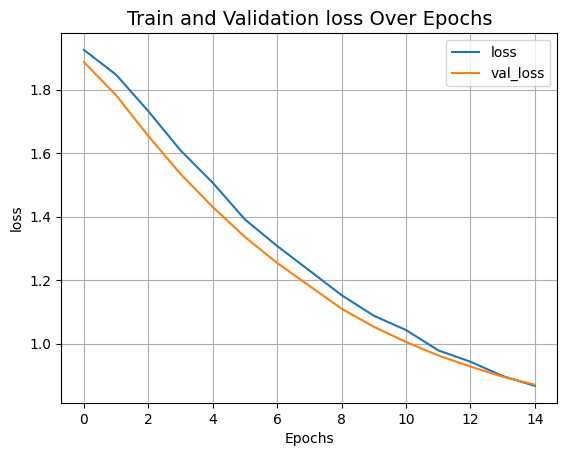

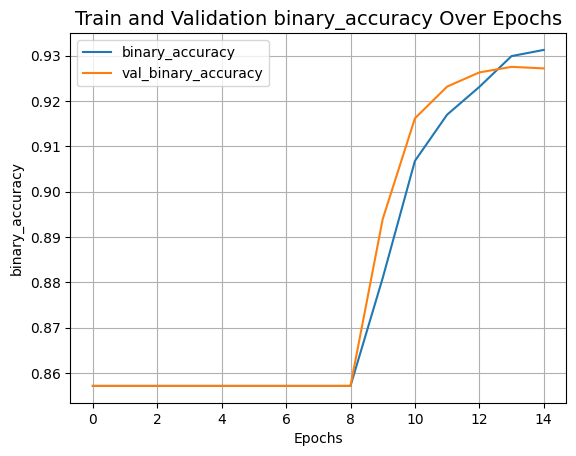

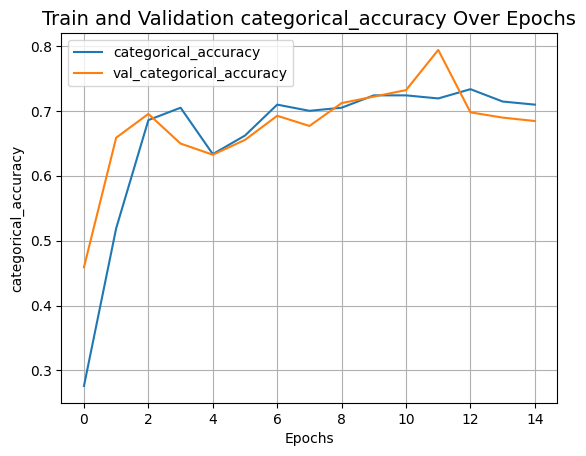

In [48]:
from matplotlib import pyplot as plt

def plot_result(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()


plot_result("loss")
plot_result("binary_accuracy")
plot_result("categorical_accuracy")

In [57]:
def max_index(arr):
    index = -1
    mx = -1
    for j in range(len(arr)):
        if arr[j] > mx:
            mx = arr[j]
            index = j

    return index


data_for_prediction = train_ds.take(1)

predictions = model.predict(data_for_prediction)

print(list(map(max_index, predictions)))

true_class = list(data_for_prediction.as_numpy_iterator())[0][-1]

print(len(true_class))

print(true_class)

print(predictions)

count = 0

cce = tf.keras.losses.CategoricalCrossentropy()

for i in range(len(predictions)):
    print("predict class =", max_index(predictions[i]), "true class =", max_index(true_class[i]))
    print(cce(predictions[i], true_class[i]).numpy())
    if max_index(predictions[i]) == max_index(true_class[i]):
        count += 1

print(count, len(list(data_for_prediction.as_numpy_iterator())[0][-1]))


1/1 [==============================] - 0s 20ms/step
[3]
1
[[0. 0. 1. 0. 0. 0. 0.]]
[[0.05658408 0.10682689 0.12448022 0.5184089  0.05907545 0.07967296
  0.05495153]]
predict class = 3 true class = 2
14.1117115
0 1
